In [1]:
from sqlalchemy.orm import sessionmaker
from sqlalchemy import and_
from typing import List
import pandas as pd
from models import engine, Trade, Record
Session = sessionmaker(bind=engine)
session = Session()

In [2]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [3]:
from itertools import permutations

TOKENS = ["DAI", "USDT", "USDC", "FRAX", "MIM", "UST"]
pairs = list(permutations(TOKENS, 2))
amounts = [1000, 10000, 100000]

In [4]:
def fetch_results(token0: str, token1: str, amount: int) -> pd.DataFrame:
    pair = '/'.join([token0, token1])
    return pd.read_sql(session.query(Record).join(Trade).filter(and_(Trade.pair == pair, Trade.amount == amount)).statement, session.bind)

In [5]:
def fetch_pair_results(token0: str, token1: str) -> pd.DataFrame:
    pair = '/'.join([token0, token1])
    return pd.read_sql(session.query(Record).join(Trade).filter(and_(Trade.pair == pair)).statement, session.bind)    

In [6]:
def fetch_all_results() -> pd.DataFrame:
    return pd.read_sql(session.query(Record).statement, session.bind)

In [11]:
def fetch_all_results_with_trades() -> pd.DataFrame:
    return pd.read_sql(session.query(Record, Trade).join(Trade, Trade.id == Record.trade).statement, session.bind)

In [52]:
df = fetch_all_results()
df

,id,exchange,amount_out,rank,original_rank,loss_pct,trade
0,1,DODOV2,9.999167e+02,1,1,0.000000,1
1,2,Curve Feeless,9.999055e+02,2,0,0.001122,1
2,3,BalancerV2,9.998332e+02,3,2,0.008353,1
3,4,CurveV2 Feeless,9.998211e+02,4,0,0.009562,1
4,5,mStable,9.997129e+02,5,3,0.020386,1
...,...,...,...,...,...,...,...
117045,117046,UniswapV3,9.986010e-13,2,2,100.000000,16108
117046,117047,Curve+UniswapV3,1.001588e+04,1,1,0.000000,16109
117047,117048,UniswapV3,9.986015e-12,2,2,100.000000,16109
117048,117049,Curve+UniswapV3,1.001328e+05,1,1,0.000000,16110


In [130]:
a = df[['exchange', 'id']].groupby(['exchange']).count()
major_dex = list(a[a['id'] > 1000].index)

# Rankings, all pairs, all amounts

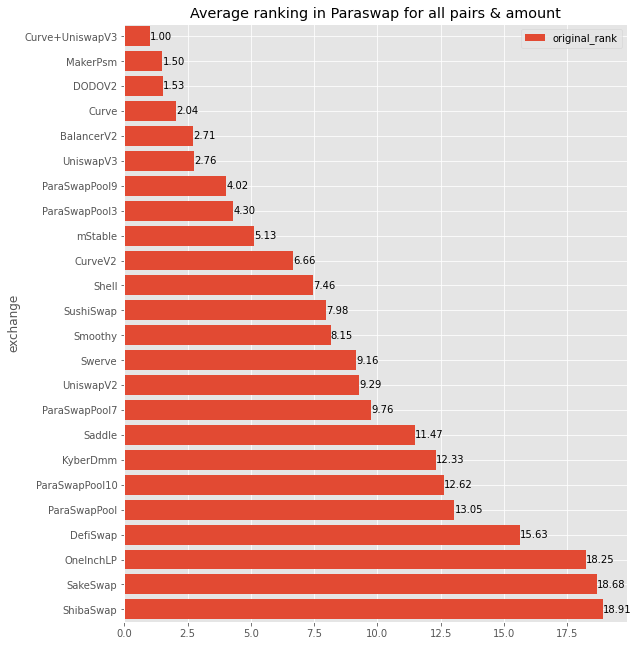

In [131]:
rankings = df[df['exchange'].isin([d for d in major_dex if 'less' not in d])][['exchange', 'original_rank']].groupby(['exchange']).mean().sort_values('original_rank', ascending=False)
ax = rankings.plot.barh(figsize=(9, 11), title='Average ranking in Paraswap for all pairs & amount')
bars = ax.barh(rankings.index, rankings['original_rank'])
ax.bar_label(bars, labels=[f'{x:,.2f}' for x in bars.datavalues])
pass

### With virtual feeless pools

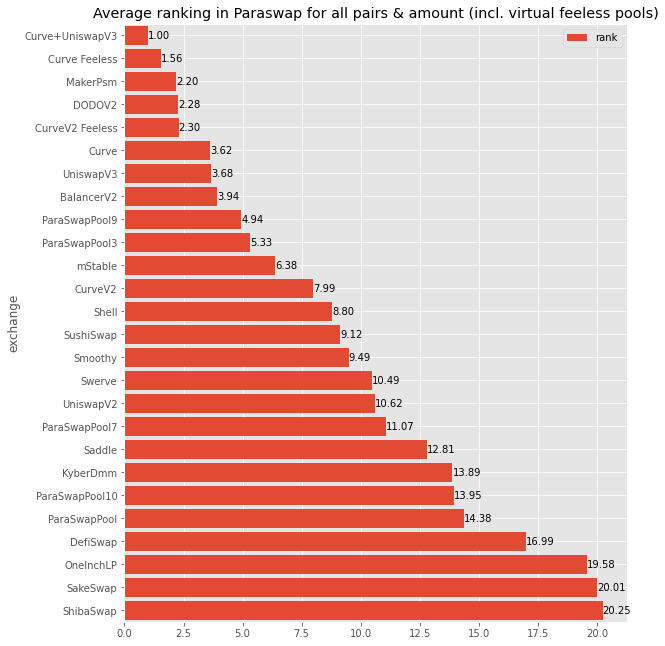

In [132]:
rankings = df[df['exchange'].isin(major_dex)][['exchange', 'rank']].groupby(['exchange']).mean().sort_values('rank', ascending=False)
ax = rankings.plot.barh(figsize=(9, 11), title='Average ranking in Paraswap for all pairs & amount (incl. virtual feeless pools)')
bars = ax.barh(rankings.index, rankings['rank'])
ax.bar_label(bars, labels=[f'{x:,.2f}' for x in bars.datavalues])
pass

# Rankings by pairs

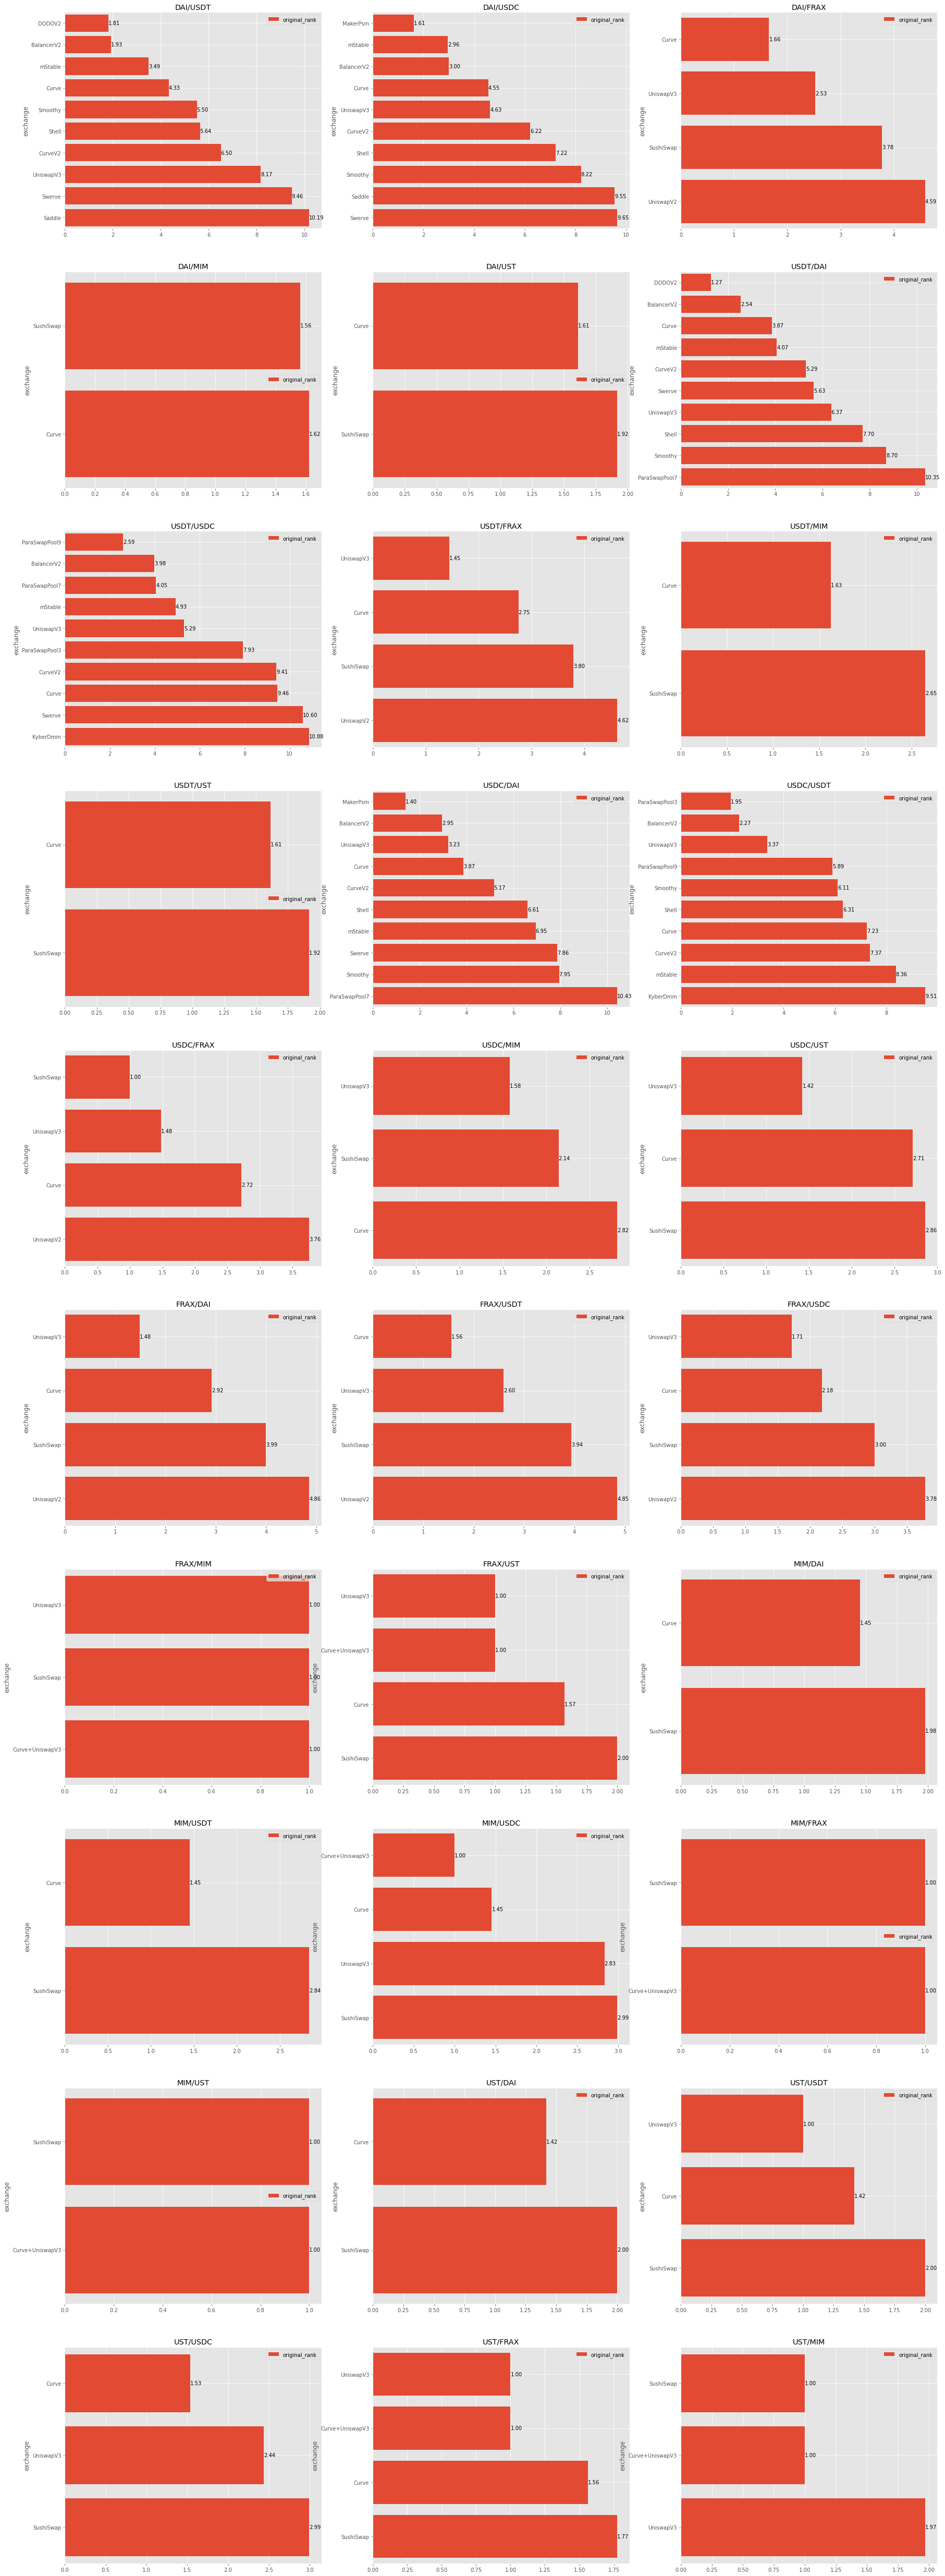

In [160]:
fig, axes = plt.subplots(nrows=len(pairs) // 3, ncols=3)
MAX_RESULTS=10
for i, pair in enumerate(pairs):
    data = fetch_pair_results(pair[0], pair[1])
    rankings = data[data['exchange'].isin([d for d in major_dex if 'less' not in d])][['exchange', 'original_rank']].groupby(['exchange']).mean().sort_values('original_rank')[:MAX_RESULTS].sort_values('original_rank', ascending=False)
    ax = rankings.plot.barh(figsize=(5, 8), ax=axes[i // 3, i % 3], title='/'.join([pair[0], pair[1]]))
    bars = ax.barh(rankings.index, rankings['original_rank'])
    ax.bar_label(bars, labels=[f'{x:,.2f}' for x in bars.datavalues])
    
fig.set_figheight(90)
fig.set_figwidth(30)

### With virtual feeless pools

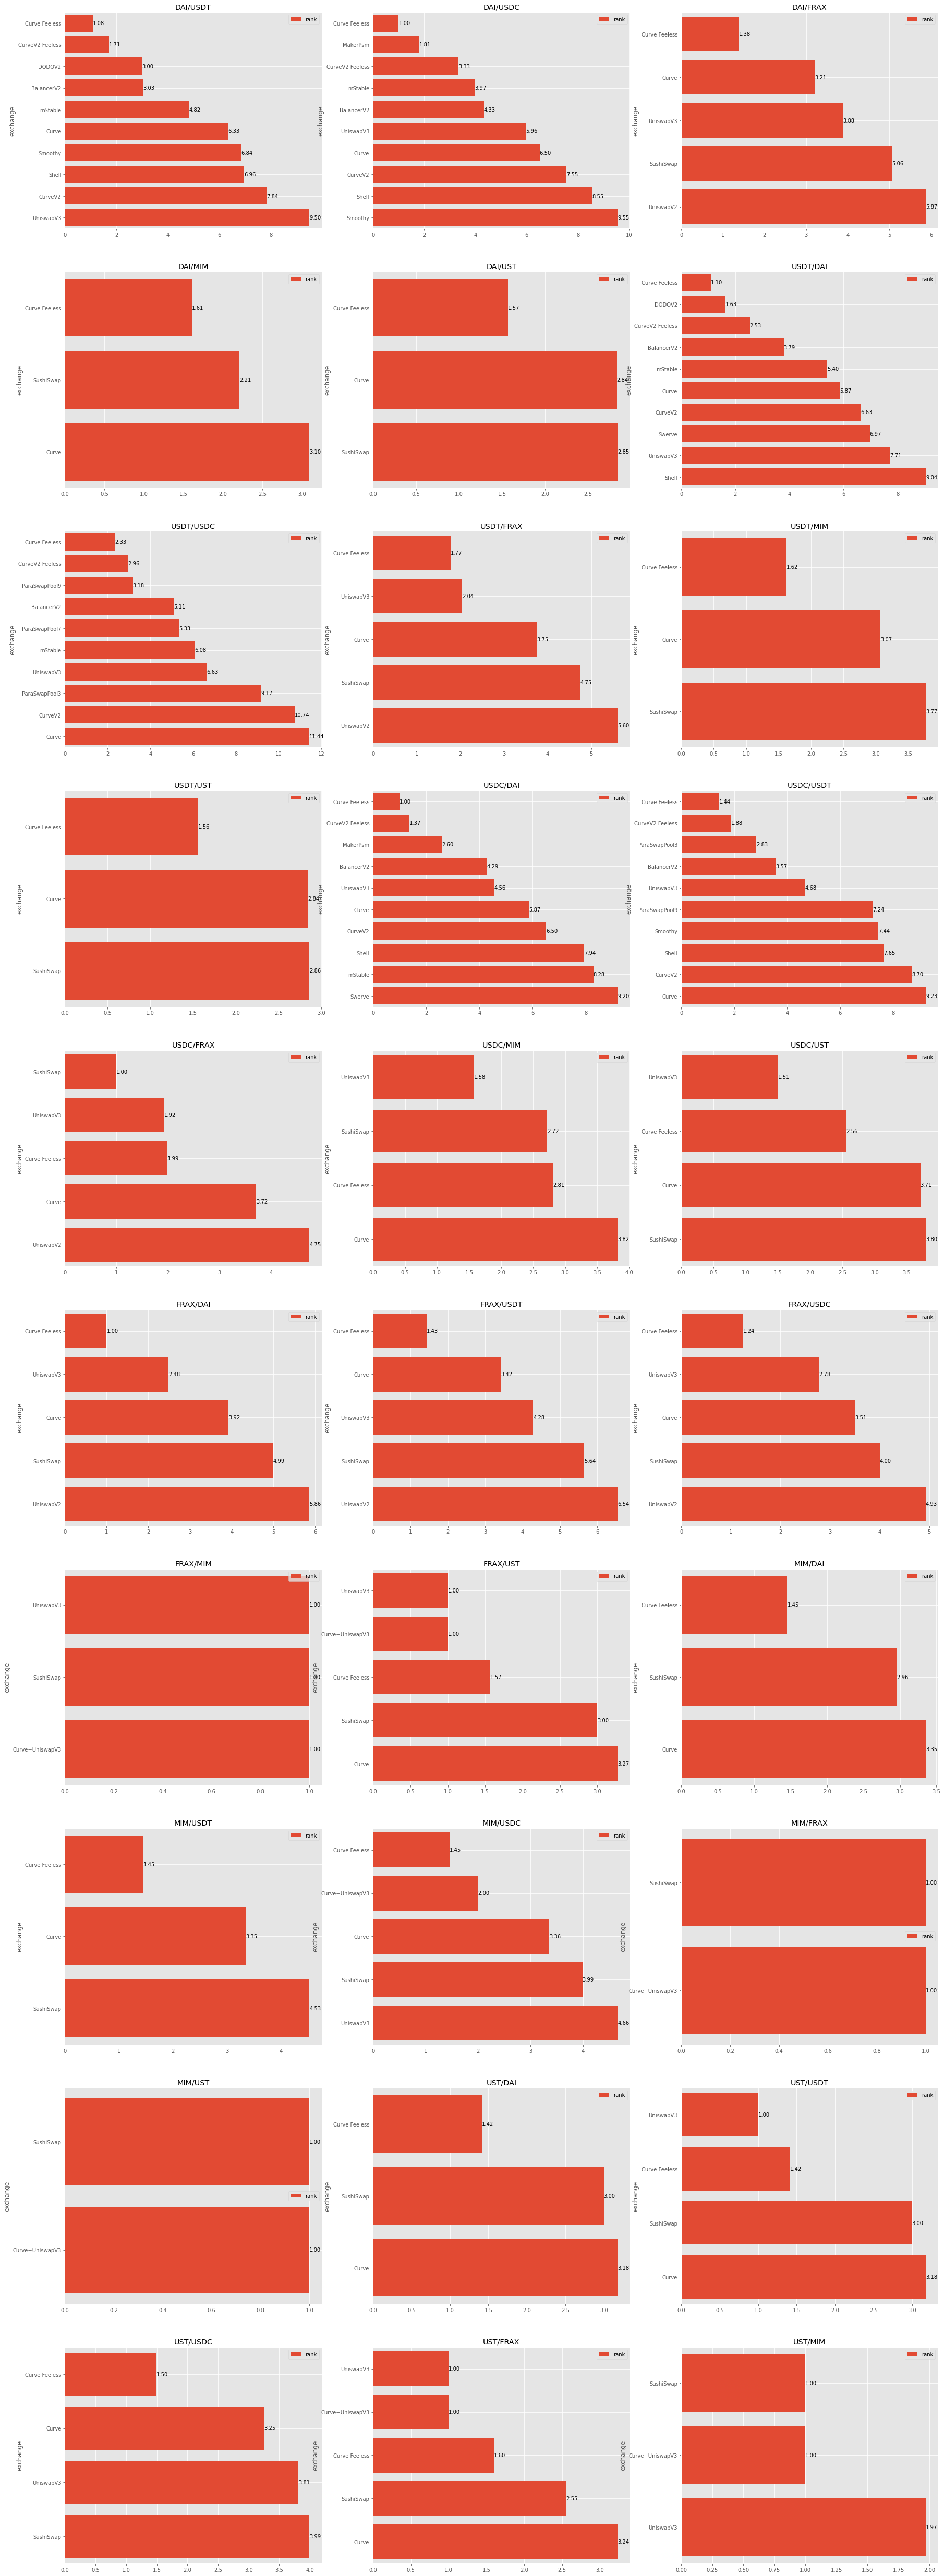

In [161]:
fig, axes = plt.subplots(nrows=len(pairs) // 3, ncols=3)
MAX_RESULTS=10
for i, pair in enumerate(pairs):
    data = fetch_pair_results(pair[0], pair[1])
    rankings = data[data['exchange'].isin(major_dex)][['exchange', 'rank']].groupby(['exchange']).mean().sort_values('rank')[:MAX_RESULTS].sort_values('rank', ascending=False)
    ax = rankings.plot.barh(figsize=(5, 8), ax=axes[i // 3, i % 3], title='/'.join([pair[0], pair[1]]))
    bars = ax.barh(rankings.index, rankings['rank'])
    ax.bar_label(bars, labels=[f'{x:,.2f}' for x in bars.datavalues])
    
fig.set_figheight(90)
fig.set_figwidth(30)

# Curve pairs ranked by performance

In [13]:
df2 = fetch_all_results_with_trades()

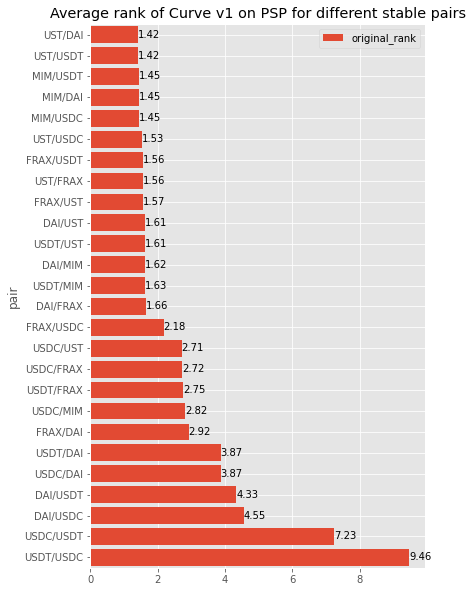

In [36]:
rankings = df2[df2['exchange'] == 'Curve'][['pair', 'original_rank']].groupby('pair').mean().sort_values('original_rank', ascending=False)
ax = rankings.plot.barh(figsize=(6,10), title='Average rank of Curve v1 on PSP for different stable pairs')
bars = ax.barh(rankings.index, rankings['original_rank'])
ax.bar_label(bars, labels=[f'{x:,.2f}' for x in bars.datavalues])
pass

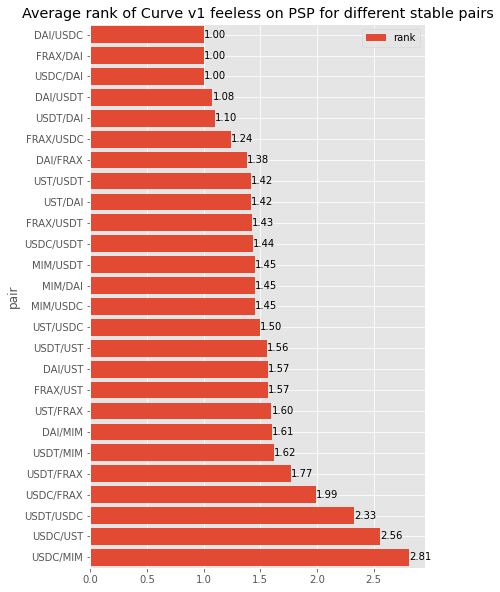

In [39]:
rankings = df2[df2['exchange'] == 'Curve Feeless'][['pair', 'rank']].groupby('pair').mean().sort_values('rank', ascending=False)
ax = rankings.plot.barh(figsize=(6,10), title='Average rank of Curve v1 feeless on PSP for different stable pairs')
bars = ax.barh(rankings.index, rankings['rank'])
ax.bar_label(bars, labels=[f'{x:,.2f}' for x in bars.datavalues])
pass